# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [1]:
%matplotlib notebook

import logging
logging.basicConfig(level=logging.ERROR)


import calendar

from datetime import timedelta, datetime

from matplotlib import pyplot as plt
#plt.style.use('dark_background')
plt.style.use('seaborn')
from matplotlib import cm

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)

from helper import *
from austria import Austria
from ecdc import ECDC

def predict_future(past_days, past_y, ndays=14, predict_days=30, degree_fit=2):
    '''
    @ndays: number of days to consider from the end for predicting future
    '''
    past_y = np.array(past_y)
    future = np.arange(0,ndays+predict_days)
    past_days = past_days.dt.to_pydatetime()
    future_days = pd.date_range(start =past_days[-ndays], 
                                end =past_days[-1]+ timedelta(days=predict_days)).to_list()

    x = np.arange(ndays)
    z = np.polyfit(x,past_y[-ndays:], degree_fit)    
    p = np.poly1d(z)    
    return future_days, p(future)

def str2float(x):
    return float(str(x).replace(',','.'))


### Data

In [2]:
def refresh_data():
    rdf_bundesland = pd.read_csv('https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',  
                quotechar='"', delimiter=';',
               encoding='iso-8859-1')
    rdf = pd.read_csv('https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',  
                quotechar='"', delimiter=';',
               encoding='iso-8859-1')


    rdf_bundesland['R_eff'] = rdf_bundesland.R_eff.apply(str2float)

    rdf['R_eff'] = rdf.R_eff.apply(str2float)

    for col in ['R_eff', 'R_eff_lwr', 'R_eff_upr']:
        rdf_bundesland[col] = rdf_bundesland[col].apply(str2float)
        rdf[col] = rdf[col].apply(str2float)

    today =f'{datetime.now().year}_{datetime.now().month:02d}_{datetime.now().day:02d}'
    ecdc = ECDC()
    AT = Austria()
    # print("TODAY: ", datetime.now(), "\nLatest case date: ", AT.epicurve.time.max(),
    #       "\nTimestamps: ", AT.epicurve.Timestamp.unique())


    vaccines = pd.read_csv('https://info.gesundheitsministerium.gv.at/data/laender.csv', delimiter=';')
    return AT, ecdc, rdf, rdf_bundesland, vaccines

AT, ecdc, rdf, rdf_bundesland, vaccines = refresh_data()

    

### Info

In [92]:
print("fälle_timeline_gkz", AT.fälle_timeline_gkz.columns)
print(AT.fälle_timeline_gkz.Bezirk.unique())
print()
print("fall_zählen", AT.fall_zählen.columns)
print(AT.fall_zählen.Bundesland.unique())
print()
print("rdf", rdf.columns)
print()
print("rdf_bundesland", rdf_bundesland.columns)
print(rdf_bundesland.Bundesland.unique())
print()
print("vaccines", vaccines.columns)

fälle_timeline_gkz Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
       'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
       'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
       'AnzahlGeheiltSum'],
      dtype='object')
['Eisenstadt(Stadt)' 'Rust(Stadt)' 'Eisenstadt-Umgebung' 'Güssing'
 'Jennersdorf' 'Mattersburg' 'Neusiedl am See' 'Oberpullendorf' 'Oberwart'
 'Klagenfurt Stadt' 'Villach Stadt' 'Hermagor' 'Klagenfurt Land'
 'Sankt Veit an der Glan' 'Spittal an der Drau' 'Villach Land'
 'Völkermarkt' 'Wolfsberg' 'Feldkirchen' 'Krems an der Donau(Stadt)'
 'Sankt Pölten(Stadt)' 'Waidhofen an der Ybbs(Stadt)'
 'Wiener Neustadt(Stadt)' 'Amstetten' 'Baden' 'Bruck an der Leitha'
 'Gänserndorf' 'Gmünd' 'Hollabrunn' 'Horn' 'Korneuburg' 'Krems(Land)'
 'Lilienfeld' 'Melk' 'Mistelbach' 'Mödling' 'Neunkirchen'
 'Sankt Pölten(Land)' 'Scheibbs' 'Tulln' 'Waidhofen an der Thaya'
 'Wiener Neustadt(Land)' 'Zwettl' 'Linz(Stadt)' 'Steyr(Stadt)'
 'Wel

## R eff.

<IPython.core.display.Javascript object>


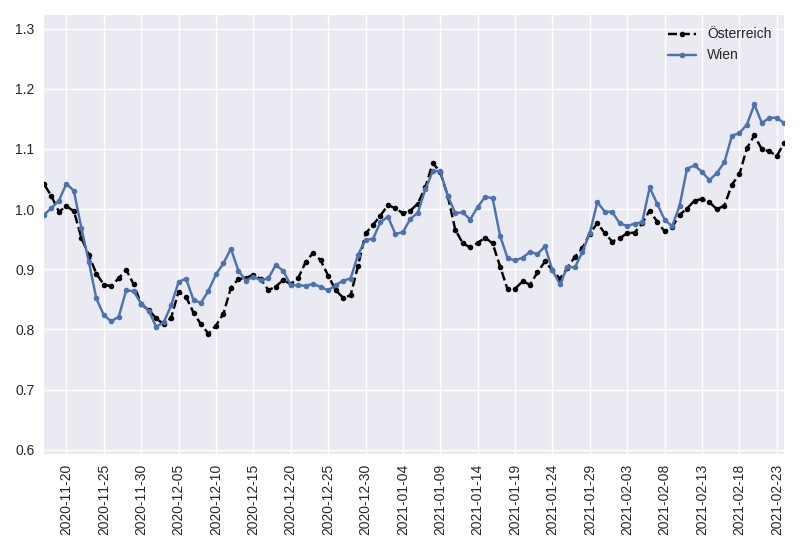

In [3]:

f, ax = plt.subplots()
ax.plot(rdf.Datum, rdf.R_eff, label='Österreich', color='k', linestyle='--', marker='o', markersize=4)

# bundesland = rdf_bundesland.Bundesland.unique()
# bundesland = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich',
#        'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg', 'Wien', 'Alle']
bundesland = [  'Wien']
viridis = cm.get_cmap('viridis', len(bundesland))
for i, bnd in enumerate(bundesland):
    df = rdf_bundesland[rdf_bundesland.Bundesland==bnd].sort_values(by='Datum')
    ax.plot(df.Datum, df.R_eff, label=bnd, 
#             color=viridis.colors[i], 
#             alpha=0.5,
            marker='o', markersize=4)
    
ndays = 100
if ndays:
    plt.xlim((rdf.Datum.iloc[-ndays], rdf.Datum.iloc[-1]))
    plt.ylim((min(rdf.R_eff.iloc[-ndays:])-0.2,max(rdf.R_eff.iloc[-ndays:])+0.2))
    
pretty_plot(ax)

In [4]:
grouped = rdf_bundesland.groupby(by='Bundesland').agg(latest)
display(grouped[grouped.R_eff>=0.95].sort_values(by='R_eff', ascending=False))
display(grouped[grouped.R_eff<0.95])
display(rdf.tail(1))

,Datum,R_eff,R_eff_lwr,R_eff_upr
Bundesland,,,,
Burgenland,2021-02-24,1.174237,1.093821,1.257464
Wien,2021-02-24,1.142597,1.111093,1.174535
Oberösterreich,2021-02-24,1.129149,1.089486,1.169511
Niederösterreich,2021-02-24,1.124455,1.092689,1.156670
Steiermark,2021-02-24,1.106664,1.069866,1.144075
Tirol,2021-02-24,1.082199,1.023898,1.142092
Kärnten,2021-02-24,1.080092,1.027069,1.134430
Salzburg,2021-02-24,1.036641,0.983325,1.091344


,Datum,R_eff,R_eff_lwr,R_eff_upr
Bundesland,,,,
Vorarlberg,2021-02-24,0.928136,0.84832,1.011488


,Datum,R_eff,R_eff_lwr,R_eff_upr
351,2021-02-24,1.110416,1.095706,1.125224


## Cases


### Weekly

<IPython.core.display.Javascript object>


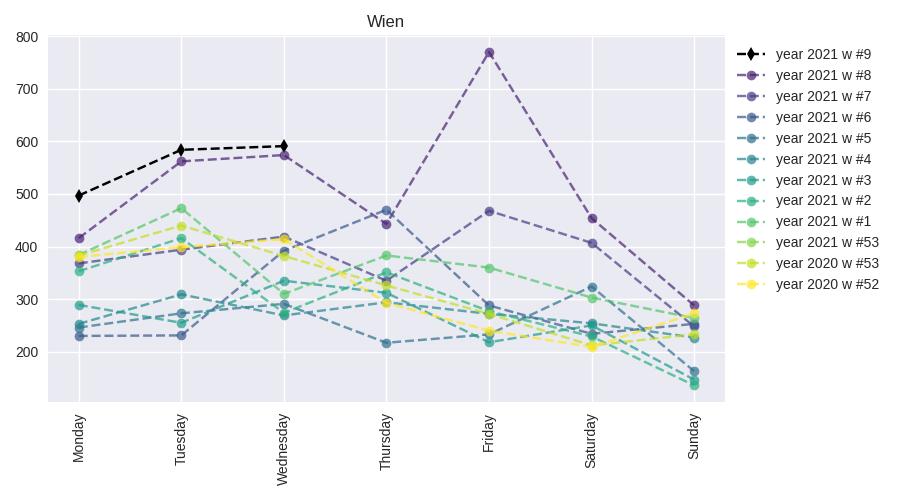

<IPython.core.display.Javascript object>


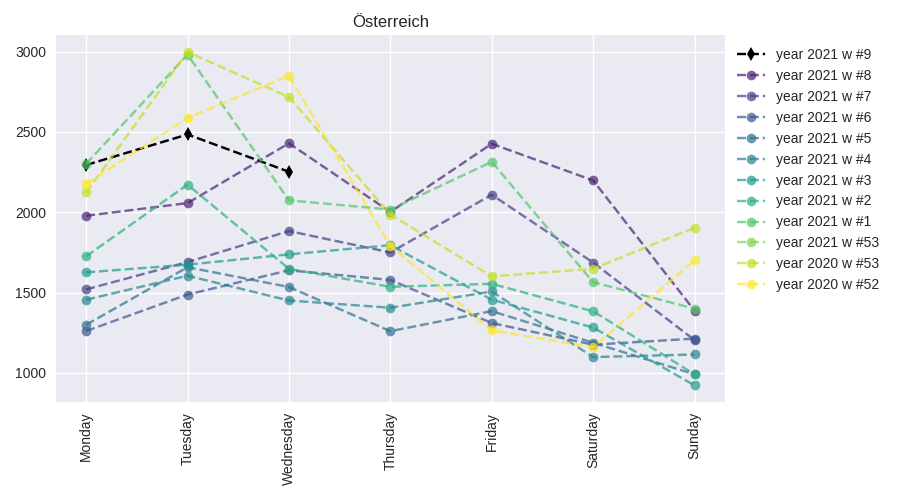

<AxesSubplot:title={'center':'Österreich'}>

In [5]:
HISTORY =12

AT.plot_cases_by_day_of_the_week(num_weeks_history=HISTORY, bezirk='Wien')
AT.plot_cases_by_day_of_the_week(num_weeks_history=HISTORY, bezirk='')


### Time Series

<IPython.core.display.Javascript object>


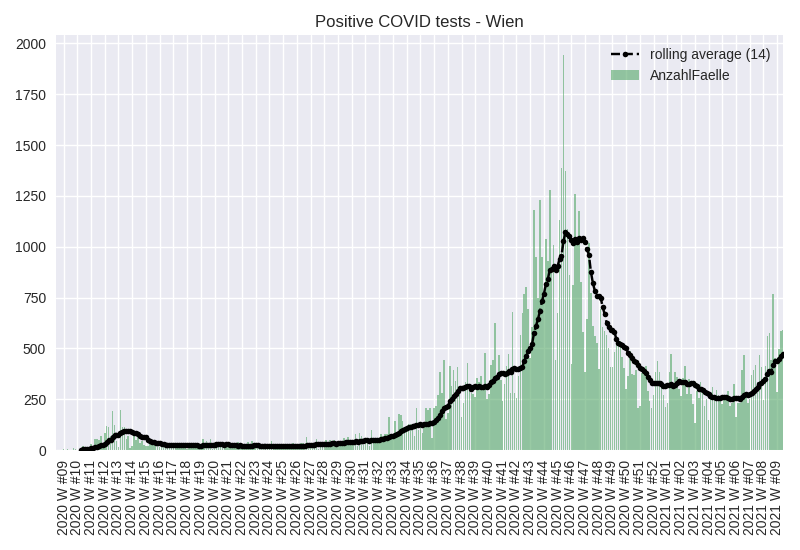

[Timestamp('2020-02-26 00:00:00'), Timestamp('2021-03-03 00:00:00')]


<IPython.core.display.Javascript object>


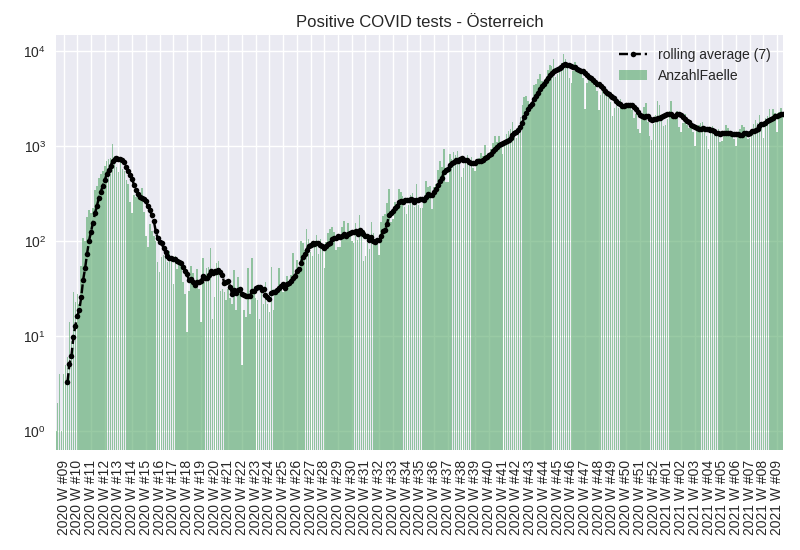

[Timestamp('2020-02-26 00:00:00'), Timestamp('2021-03-03 00:00:00')]


In [45]:

# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax = AT.plot_tägliche_erkrankungen(roll_days=14, ndays=0, bezirk='Wien')
# plt.yscale('log')

ax = AT.plot_tägliche_erkrankungen(roll_days=7, ndays=0, bezirk=None)

plt.yscale('log')



# selection =  ecdc.select_country('AT',   ndays=1000,).sort_values(by=['dateRep'], ascending=True,)
# # ax.plot(,.rolling(14).mean(), marker='o', markersize=4, linestyle='--')
# ax = plot_rolling_avg(ax,selection.dateRep, y= selection['cases_weekly'], roll_days=14, label='ECDC', color='C0')



# AT.epicurve['tägliche Erkrankungen'], ecdc.select_country('AT').cases_weekly.sum()



### Weekly Totals

In [6]:
wien_cases = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk=='Wien']
display(wien_cases.tail())


,Time,Bezirk,GKZ,AnzEinwohner,AnzahlFaelle,AnzahlFaelleSum,AnzahlFaelle7Tage,SiebenTageInzidenzFaelle,AnzahlTotTaeglich,AnzahlTotSum,AnzahlGeheiltTaeglich,AnzahlGeheiltSum
34591,2021-02-27,Wien,900,1911191,454,91014,3467,"181,4052",6,1694,311,80322
34685,2021-02-28,Wien,900,1911191,288,91302,3507,"183,4981",7,1701,154,80476
34779,2021-03-01,Wien,900,1911191,497,91799,3588,"187,7363",3,1704,223,80699
34873,2021-03-02,Wien,900,1911191,584,92383,3610,"188,8875",6,1710,221,80920
34967,2021-03-03,Wien,900,1911191,591,92974,3627,"189,7769",5,1715,376,81296


### Cases prediction

<IPython.core.display.Javascript object>


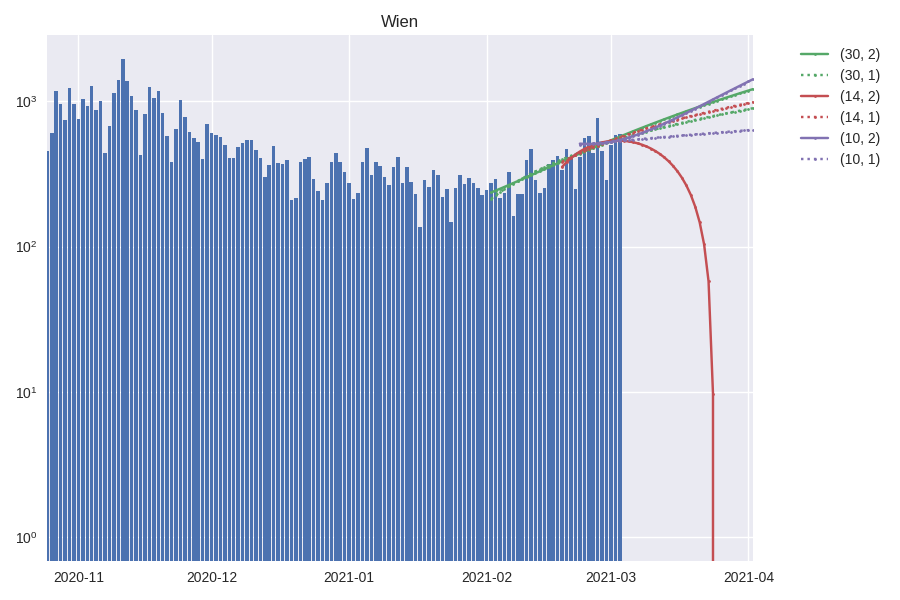

In [7]:

f, ax = plt.subplots(figsize=(9,6))
# ax.bar(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'])
ax.bar(wien_cases.Time, wien_cases.AnzahlFaelle)
HISTORY = [30,14,10]
DEGREES = [2,1]
LINESTYLES = ['solid',
              'dotted', 'dashed','dashdot',
              'loosely dashed','loosely dotted', 'loosely dashdotdotted',
              'densely dashed', 'loosely dashdotted','densely dashdotdotted']   

for i, hist in  enumerate(HISTORY) :
    for j, df in enumerate(DEGREES):
        x, y = predict_future(wien_cases.Time, wien_cases.AnzahlFaelle, ndays=hist, predict_days=30, degree_fit=df)        
        ax.plot(x, y, label=f'({hist}, {df})', linestyle=LINESTYLES[j], marker='o', markersize=2, color=f'C{i+1}')
        
# plt.legend(loc='best')
# print([x[-1],wien_cases.Time.iloc[-50]])
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([wien_cases.Time.iloc[-max(HISTORY)-100],x[-1]])
plt.title('Wien')
# pretty_plot(ax, log=True)
plt.yscale('log')
plt.tight_layout()

## Positivity Rate

### Vienna

2021-03-03 00:00:00


<IPython.core.display.Javascript object>


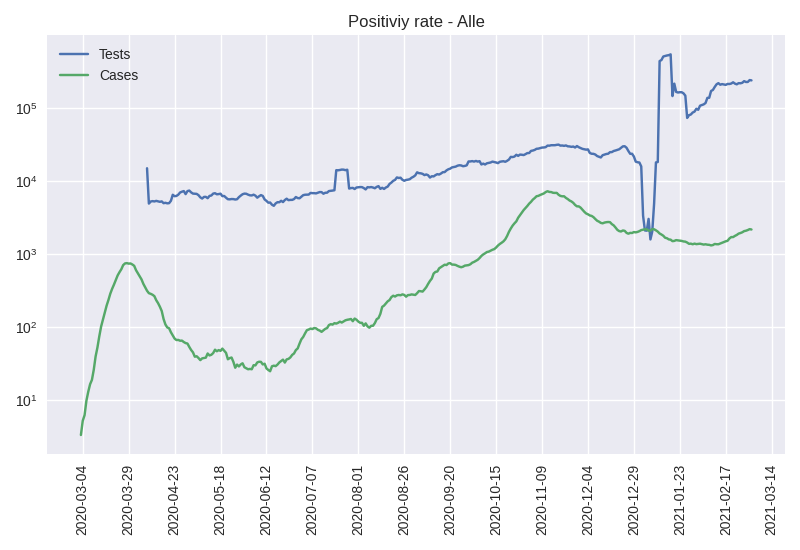

<AxesSubplot:title={'center':'Positiviy rate - Alle'}>

In [8]:
AT.plot_positivity_rate(bundesland='Alle')
# 

# AT.plot_positivity_rate(bundesland='Wien')

## Corona Ampel

In [9]:
ampel = AT.ampel_aktuell

# ampel.sort_values('Warnstufe', ascending=False).head(10)
ampel.groupby('Warnstufe').agg({'Name':concat, 'Region': 'count'})

,Name,Region
Warnstufe,,
3,"Bludenz, Bregenz, Dornbirn, Feldkirch, Vorarlberg, Bartholomäberg, Blons, Bludenz, Bludesch, Brand, Bürs, Bürserberg, Dalaas, Fontanella, Gaschurn, Innerbraz, Klösterle, Lech, Lorüns, Ludesch, Nenzing, Nüziders, Raggal, St. Anton im Montafon, St. Gallenkirch, St. Gerold, Schruns, Silbertal, Sonntag, Stallehr, Thüringen, Thüringerberg, Tschagguns, Vandans, Alberschwende, Andelsbuch, Au, Bezau, Bildstein, Bizau, Bregenz, Buch, Damüls, Doren, Egg, Eichenberg, Fußach, Gaißau, Hard, Hittisau, Höchst, Hörbranz, Hohenweiler, Kennelbach, Krumbach, Langen bei Bregenz, Langenegg, Lauterach, Lingenau, Lochau, Mellau, Mittelberg, Möggers, Reuthe, Riefensberg, Schnepfau, Schoppernau, Schröcken, Schwarzach, Schwarzenberg, Sibratsgfäll, Sulzberg, Warth, Wolfurt, Dornbirn, Hohenems, Lustenau, Altach, Düns, Dünserberg, Feldkirch, Frastanz, Fraxern, Göfis, Götzis, Klaus, Koblach, Laterns, Mäder, Meiningen, Rankweil, Röns, Röthis, Satteins, Schlins, Schnifis, Sulz, Übersaxen, Viktorsberg, Weiler, Zwischenwasser",101
4,"Eisenstadt(Stadt), Rust(Stadt), Eisenstadt-Umgebung, Güssing, Jennersdorf, Mattersburg, Neusiedl am See, Oberpullendorf, Oberwart, Klagenfurt Stadt, Villach Stadt, Hermagor, Klagenfurt Land, Sankt Veit an der Glan, Spittal an der Drau, Villach Land, Völkermarkt, Wolfsberg, Feldkirchen, Krems an der Donau(Stadt), Sankt Pölten(Stadt), Waidhofen an der Ybbs(Stadt), Wiener Neustadt(Stadt), Amstetten, Baden, Bruck an der Leitha, Gänserndorf, Gmünd, Hollabrunn, Horn, Korneuburg, Krems(Land), Lilienfeld, Melk, Mistelbach, Mödling, Neunkirchen, Sankt Pölten(Land), Scheibbs, Tulln, Waidhofen an der Thaya, Wiener Neustadt(Land), Zwettl, Linz(Stadt), Steyr(Stadt), Wels(Stadt), Braunau am Inn, Eferding, Freistadt, Gmunden, Grieskirchen, Kirchdorf an der Krems, Linz-Land, Perg, Ried im Innkreis, Rohrbach, Schärding, Steyr-Land, Urfahr-Umgebung, Vöcklabruck, Wels-Land, Salzburg(Stadt), Hallein, Salzburg-Umgebung, Sankt Johann im Pongau, Tamsweg, Zell am See, Graz(Stadt), Deutschlandsberg, Graz-Umgebung, Leibnitz, Leoben, Liezen, Murau, Voitsberg, Weiz, Murtal, Bruck-Mürzzuschlag, Hartberg-Fürstenfeld, Südoststeiermark, Innsbruck-Stadt, Imst, Innsbruck-Land, Kitzbühel, Kufstein, Landeck, Lienz, Reutte, Schwaz, Burgenland, Kärnten, Niederösterreich, Oberösterreich, Salzburg, Steiermark, Tirol, Wien, None",98


## Future Occupancy

In [10]:
NDAYS=30
latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
print(f'As of {AT.fall_zählen.MeldeDatum.max()}')
data = []
for bundesland in AT.fall_zählen.Bundesland.unique():
    bundesland_data = {'bundesland': bundesland}
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]
    bundesland_data['ICUFree'] = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]
    bundesland_data['HospFree'] = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]
    predict_days =  300
    days_left_icu = []
    days_left_hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_icu.append( np.argmax(y>=limit_ICU)-NDAYS)
        else:
            days_left_icu.append(1000)

        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_hosp.append( np.argmax(y>=limit_Hosp)-NDAYS)
        else:
            days_left_hosp.append( 1000)


        
    bundesland_data['daysLeftICU'] = days_left_icu    
    bundesland_data['ICUMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_icu)))
    bundesland_data['ICUMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_icu)))
    bundesland_data['daysLeftHosp'] = days_left_hosp
    
    bundesland_data['HospMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_hosp)))
    bundesland_data['HospMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_hosp)))

    data.append(bundesland_data)
    
df_future = pd.DataFrame(data)
df_future.sort_values(by='ICUFree')

As of 2021-03-03 00:00:00


,bundesland,ICUFree,HospFree,daysLeftICU,ICUMax_worst,ICUMax_best,daysLeftHosp,HospMax_worst,HospMax_best
0,Burgenland,9,98,"[56, 17, 1000]",2021-03-20,2023-11-28,"[1000, 1000, 1000]",2023-11-28,2023-11-28
1,Kärnten,26,227,"[140, 16, 10]",2021-03-13,2021-07-21,"[1000, 76, 76]",2021-05-18,2023-11-28
6,Tirol,31,191,"[1000, 23, 19]",2021-03-22,2023-11-28,"[1000, 40, 38]",2021-04-10,2023-11-28
4,Salzburg,34,133,"[1000, 17, 10]",2021-03-13,2023-11-28,"[1000, 61, 48]",2021-04-20,2023-11-28
3,Oberösterreich,57,297,"[1000, 29, 12]",2021-03-15,2023-11-28,"[1000, 50, 37]",2021-04-09,2023-11-28
7,Vorarlberg,62,119,"[1000, 1000, 1000]",2023-11-28,2023-11-28,"[1000, 37, 1000]",2021-04-09,2023-11-28
5,Steiermark,64,376,"[1000, 85, 1000]",2021-05-27,2023-11-28,"[1000, 74, 14]",2021-03-17,2023-11-28
2,Niederösterreich,89,730,"[104, 26, 15]",2021-03-18,2021-06-15,"[1000, 44, 27]",2021-03-30,2023-11-28
8,Wien,168,1907,"[1000, 62, 14]",2021-03-17,2023-11-28,"[1000, 76, 62]",2021-05-04,2023-11-28
9,Alle,540,4078,"[1000, 36, 19]",2021-03-22,2023-11-28,"[1000, 60, 34]",2021-04-06,2023-11-28


### Plots

<IPython.core.display.Javascript object>


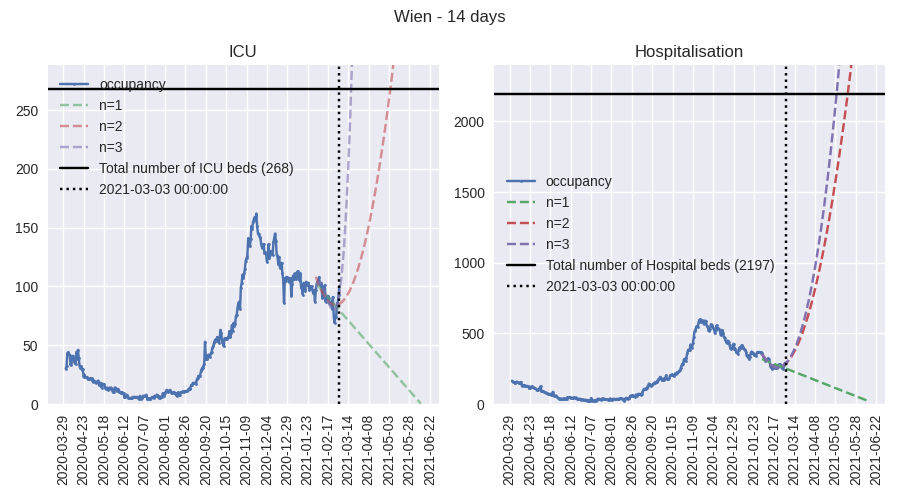

<IPython.core.display.Javascript object>


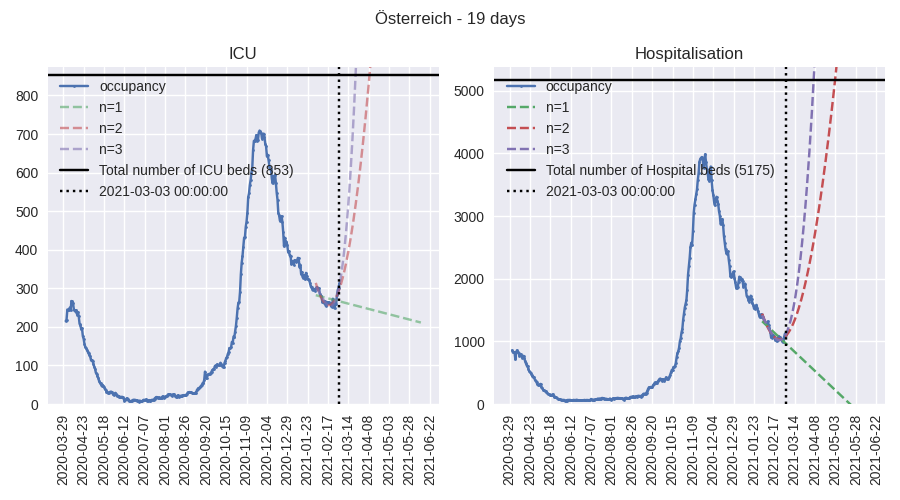

In [11]:
PREDICTION_HISTORY = 100

latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
for bundesland in [ 'Wien', 'Alle']:
    f, ax = plt.subplots(ncols=2,sharex=True, figsize=(9,5))
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + \
                latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + \
                 latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]

    predict_days =  max(int(latest_df.FZICUFree.iloc[0]),PREDICTION_HISTORY)

    ax[0].plot(df.MeldeDatum, df.FZICU, label='occupancy', marker='o',markersize=2)
    ax[1].plot(df.MeldeDatum, df.FZHosp, label='occupancy', marker='o',markersize=2)

#     print(latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    days_left_ICU = []
    days_left_Hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        
        ax[0].plot(x, y, linestyle='--', label=f'n={degree_fit}', alpha=0.6)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_ICU.append(np.argmax(y>=limit_ICU)-NDAYS)
       
        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        ax[1].plot(x, y, linestyle='--', label=f'n={degree_fit}')
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_Hosp.append(np.argmax(y>=limit_Hosp)-NDAYS)
        
    ax[0].axhline(y=limit_ICU,color='k', label=f'Total number of ICU beds ({limit_ICU})')
    ax[1].axhline(y=limit_Hosp,color='k', label=f'Total number of Hospital beds ({limit_Hosp})')
    ax[0].set_ylim(0,limit_ICU+20)
    ax[1].set_ylim(0,limit_Hosp+200)
    ax[0].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    ax[1].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])

    title = bundesland if bundesland != 'Alle' else 'Österreich'
    if days_left_ICU:
        title = f'{title} - {min(days_left_ICU)} days'
    
    f.suptitle(title)
    ax[0].set_ylim(0,)
    pretty_plot(ax[0], title='ICU')
    pretty_plot(ax[1],title='Hospitalisation')
        
#     plt.savefig(f'ICU_{today}_{bundesland}.png')



## Bed capacity

<IPython.core.display.Javascript object>


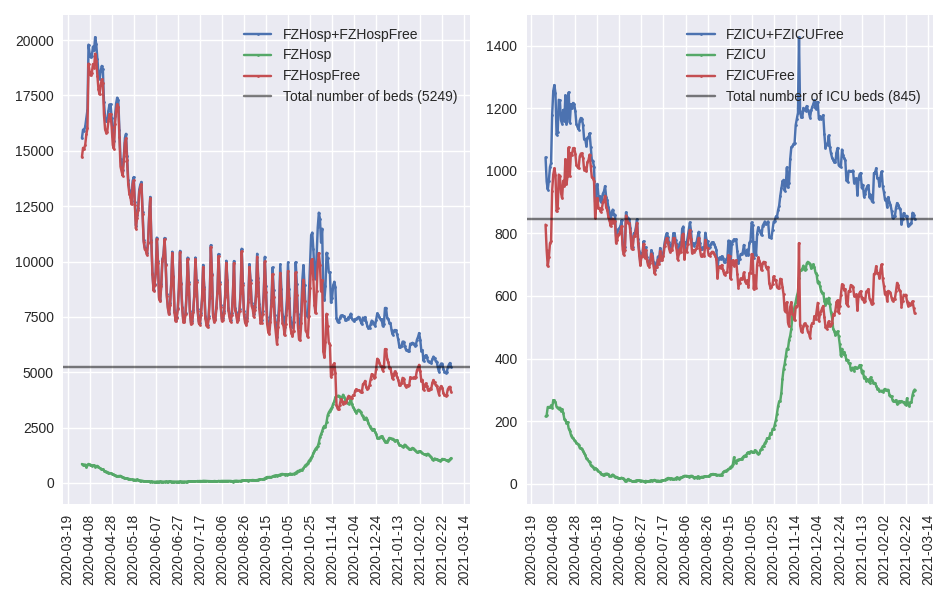

In [20]:
df = AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle']

f,ax = plt.subplots(ncols=2, figsize=(9.5,6))
ax[0].plot(df.MeldeDatum, df.FZHosp+df.FZHospFree, label='FZHosp+FZHospFree',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHosp, label='FZHosp',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHospFree, label='FZHospFree',markersize=2, marker='o') 
ax[1].plot(df.MeldeDatum, df.FZICU+df.FZICUFree, label='FZICU+FZICUFree',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICU, label='FZICU',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICUFree, label='FZICUFree',markersize=2, marker='o')    
ax[0].axhline(y=df.FZHospFree.iloc[-1]+df.FZHosp.iloc[-1],color='k', label=f'Total number of beds ({limit_Hosp})',alpha=0.5)
ax[1].axhline(y=df.FZICUFree.iloc[-1]+df.FZICU.iloc[-1],color='k', label=f'Total number of ICU beds ({limit_ICU})',alpha=0.5)
# ax[0].set_ylabel('Number of Hospital Beds')
# ax[1].set_ylabel('Number of ICU Beds')
pretty_plot(ax[0])
pretty_plot(ax[1])

## Deaths

In [21]:
from gestorbene import Gestorbene
G = Gestorbene()
max(G.under_65.week_end)

Timestamp('2021-02-14 00:00:00')

### Overall Deaths

<IPython.core.display.Javascript object>


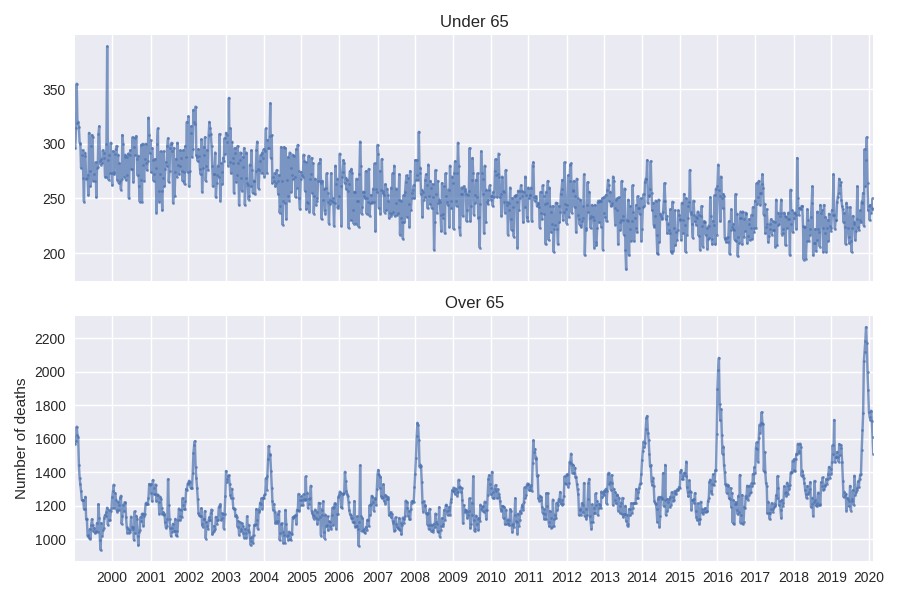

In [17]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

<IPython.core.display.Javascript object>


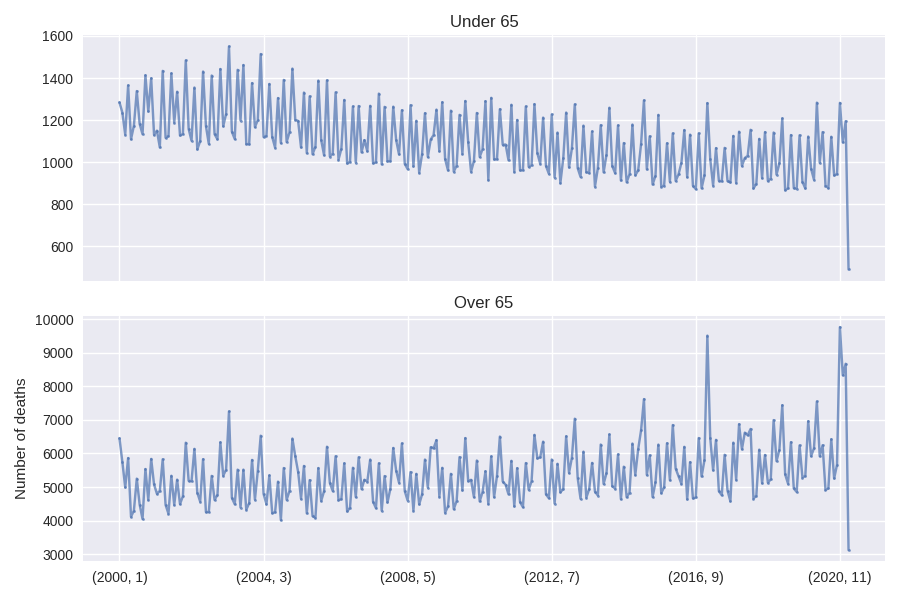

In [18]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')

f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
# ax[1].xaxis.set_major_locator(plt.MaxNLocator(50));

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

plt.tight_layout()

### By Sex

<IPython.core.display.Javascript object>


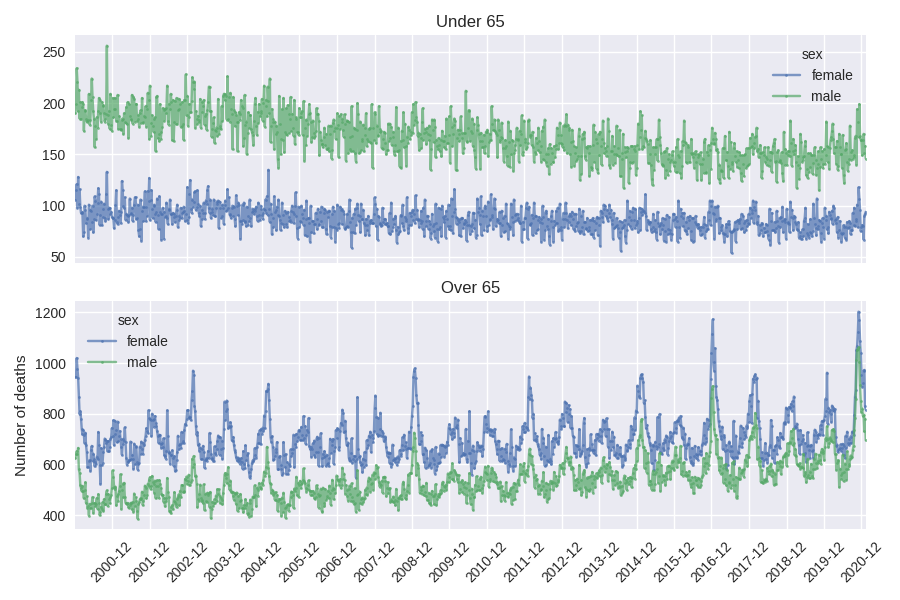

In [19]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'));
plt.tight_layout()

### Yearly

<IPython.core.display.Javascript object>


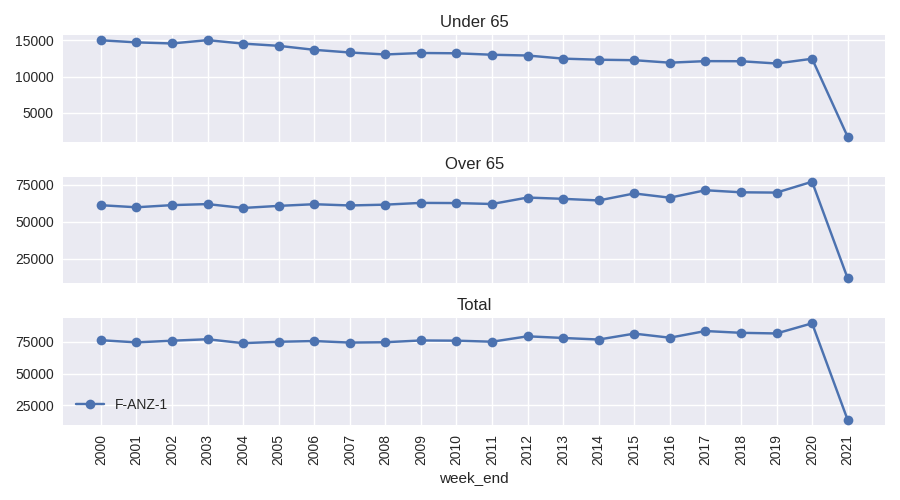

In [20]:
current_year = datetime.now().year
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,5),nrows=len(dfs), sharex=True, sharey=False)
i = 0
for title, df in dfs.items():
    grouped = df.groupby(by=[df.week_end.dt.year]).agg('sum')
    grouped.head()
    grouped['F-ANZ-1'].plot(ax=ax[i], marker='o', title=title)
    i += 1
# 
pretty_plot(ax[-1],xticks=[df.week_end.dt.year.unique(),])


## Total number of deaths in Austria in 2020

### COVID

### All deaths

In [21]:
all_deaths = pd.concat([G.under_65, G.over_65])
all_deaths[all_deaths.week_end.dt.year == 2020]['F-ANZ-1'].sum()

89549

## Cumulative deaths in a year

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


<IPython.core.display.Javascript object>


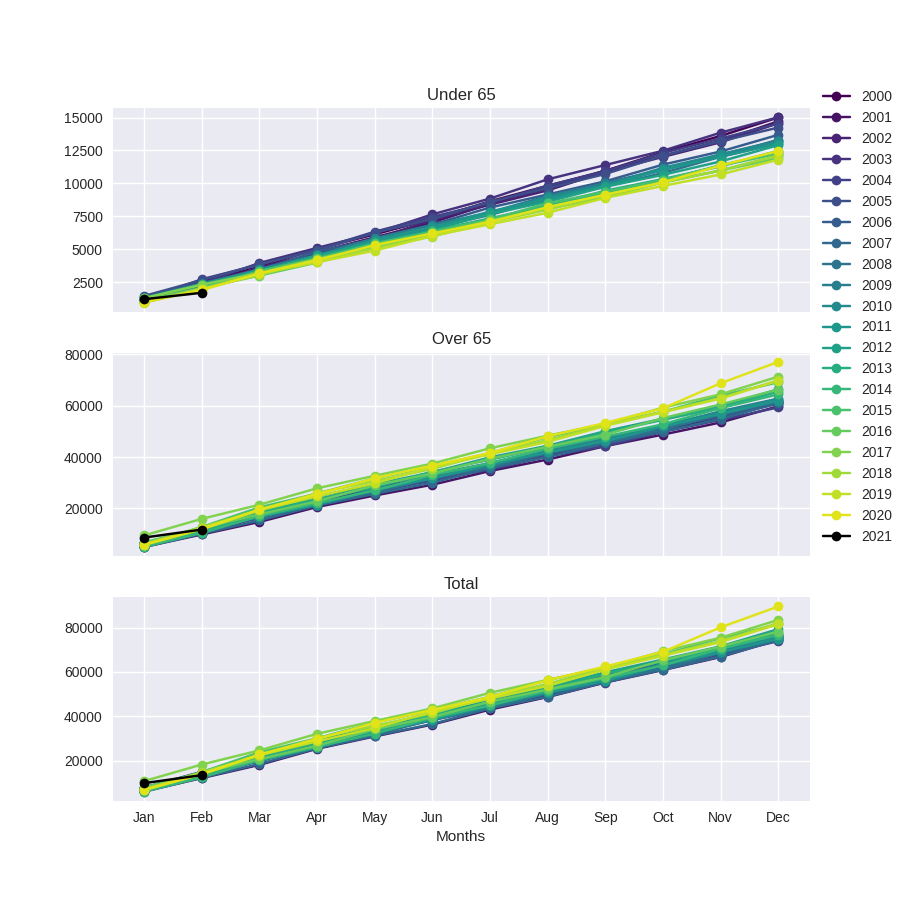

<ipython-input-22-4b56755a600d>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


In [22]:
current_year = datetime.now().year
NUM_YEARS = 10
YEARS = sorted(list(all_deaths.week_end.dt.year.unique()))
print(YEARS)
viridis = cm.get_cmap('viridis', len(YEARS))

# df.head()
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,9),nrows=len(dfs), sharex=True, sharey=False)
j = -1
for title, all_deaths in dfs.items():
    j += 1
    for i, y in enumerate(YEARS):    
        if y == current_year:
            color='k'
        else:
            color=viridis.colors[i]
            
        df_year = all_deaths[all_deaths.week_end.dt.year == y]
        grouped = df_year.groupby(by=[all_deaths.week_end.dt.month]).agg('sum')        
        grouped['F-ANZ-1'].cumsum().plot(ax=ax[j], marker='o',label=y, title=title,c=color)
    

plt.xlabel('Months')    
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(bbox_to_anchor=(1, 1.2), loc='lower left')    

plt.tight_layout()
    
